In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Cardiac\ Project/Registration_phase/based \on \doc2

/content/drive/MyDrive/Cardiac Project/Registration_phase/based on doc2


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable
from torchvision import transforms

import random
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
torch.manual_seed(17)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
use_gpu = torch.cuda.is_available()

random.seed(42)

In [4]:
def read_dataset(path):

    dataset = []
    oks = os.listdir(path)
    for ok in tqdm(oks):
        ok_path = path + "/" + ok 
        patients = os.listdir(ok_path)
        i = 0
        for patient_id in  patients:
            folders_path = path + "/" + ok + "/" + patient_id
            
            folders = os.listdir(folders_path)
            folders = [folder for folder in folders if len(folder)==1]
            
            for folder in folders:
                result_path = path + "/" + ok + "/" + patient_id + "/" + folder + '/results/'
                i+=1
                if not os.path.exists(result_path):
                    continue                
                image_names = os.listdir(result_path)
                if len(image_names)>4:
                    for image_name in image_names:
                        
                        if "cine" in image_name:
                            cine_path = result_path + image_name
                            cine_image = cv2.imread(cine_path , cv2.IMREAD_GRAYSCALE)
                        
                        if "rigid_lge" in image_name and len(image_name) == 13:
                            lge_path = result_path + image_name
                            rigid_lge_image = cv2.imread(lge_path , cv2.IMREAD_GRAYSCALE) 


                        if "rigid_mask" in image_name :

                            mask_path = result_path + image_name
                            rigid_mask_image = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE) 

                        if "scar_eliminated" in image_name:
                            el_path = result_path + image_name
                            scar_eliminated_image = cv2.imread(el_path , cv2.IMREAD_GRAYSCALE) 

                        else:
                            continue

                    dataset.append((cine_image , scar_eliminated_image , rigid_lge_image, rigid_mask_image, result_path ))
            
    print("Images Readed.")
    return dataset

In [ ]:
dataset = read_dataset("dataset")

100%|██████████| 4/4 [05:36<00:00, 84.19s/it]

Images Readed.


In [ ]:
len(dataset)

202

In [ ]:
train_dataset , test_dataset = train_test_split(dataset, test_size=0.1, shuffle = False)

In [ ]:
len(train_dataset)

181

In [ ]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [ ]:
def transform(image , angle , flip_H , flip_V):
    image = rotate_image(image, angle)
    if flip_H:
        image = cv2.flip(image, 0)
    if flip_V:
        image = cv2.flip(image, 1)
    return image

In [ ]:
def Augmentation(dataset , augment = False):
    new_dataset = []
    for element in dataset:
        transformed_element = []

        angle = random.randrange(start=-15, stop = 15 , step = 1)
        flip_H = random.choice([0,1])
        flip_V = random.choice([0,1])
        for image in element[:-1]:
            transformed_image = transform(image , angle , flip_H , flip_V)
            transformed_element.append(transformed_image)
        transformed_element = transformed_element + [element[-1]]
        new_dataset.append(transformed_element)
    return new_dataset

In [ ]:
aug1 = Augmentation(train_dataset)

In [ ]:
aug2 = Augmentation(train_dataset)

In [ ]:
train_dataset =aug1 + aug2 + train_dataset

In [ ]:
len(train_dataset)

543

path: dataset/ok1,2/1551489/4/results/


Text(0.5, 1.0, 'rigid mask')

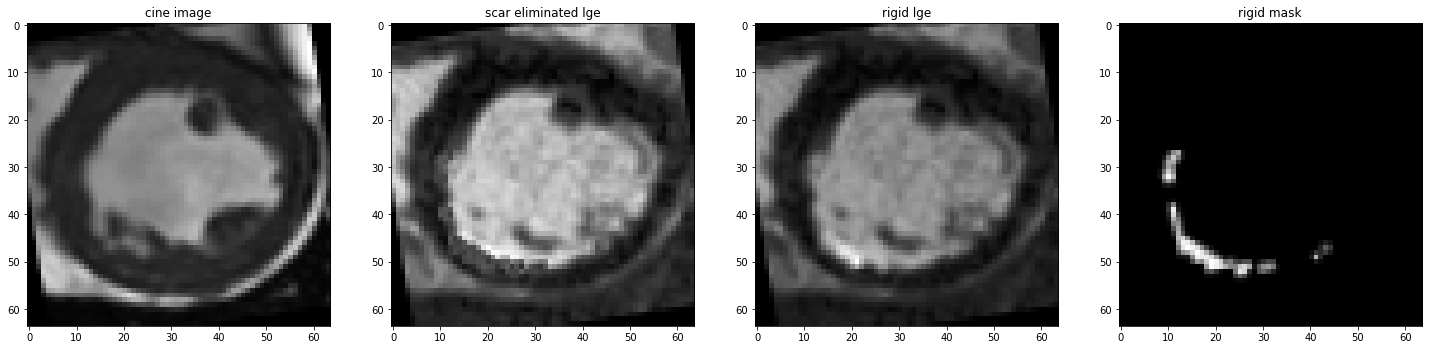

In [ ]:
fig , (ax1 , ax2 , ax3 , ax4) = plt.subplots(1,4,figsize = (25,12))
cine_image , scar_eliminated_image , rigid_lge_image, rigid_mask_image  ,result_path = train_dataset[30]

print("path:" , result_path)

ax1.imshow(cine_image, cmap = 'gray')
ax1.set_title("cine image")

ax2.imshow(scar_eliminated_image , cmap = 'gray')
ax2.set_title("scar eliminated lge")

ax3.imshow(rigid_lge_image , cmap = 'gray')
ax3.set_title("rigid lge")

ax4.imshow(rigid_mask_image, cmap = 'gray')
ax4.set_title("rigid mask")

In [ ]:
from skimage import exposure

In [ ]:
def preprocess(dataset):
    T_dataset = []
    for element in dataset:
        items = []
        for i , item in enumerate(element[:-1]):
            item = transforms.ToTensor()(item)
            #if i == 1:
                #matched = exposure.match_histograms(element[i], element[i-1])
                #matched = matched/matched.max()
                #matched *= 255
                #item = matched.astype(np.uint8)
            items.append(item)
        items = items + [element[-1]]
        T_dataset.append(items)
    return T_dataset

In [ ]:
train_dataset = preprocess(train_dataset)
test_dataset = preprocess(test_dataset)

In [ ]:
train_loader = data.DataLoader(train_dataset,batch_size = 1,shuffle = True)  
test_loader = data.DataLoader(test_dataset ,batch_size = 1,shuffle = False)     

In [ ]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        """
        This function creates one contracting block
        """
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This function creates one expansive block
        """
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.ReLU(),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        return block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This returns final block
        """
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.ReLU()
                )
        return block

    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=32)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(32, 64)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(64, 128)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        mid_channel = 128
        self.bottleneck = torch.nn.Sequential(
                                torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel, out_channels=mid_channel * 2, padding=1),
                                torch.nn.BatchNorm2d(mid_channel * 2),
                                torch.nn.ReLU(),
                                torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel*2, out_channels=mid_channel, padding=1),
                                torch.nn.BatchNorm2d(mid_channel),
                                torch.nn.ReLU(),
                                torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=mid_channel, kernel_size=3, stride=2, padding=1, output_padding=1),
                                torch.nn.BatchNorm2d(mid_channel),
                                torch.nn.ReLU(),
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(256, 128, 64)
        self.conv_decode2 = self.expansive_block(128, 64, 32)
        self.final_layer = self.final_block(64, 32, out_channel)

    def crop_and_concat(self, upsampled, bypass, crop=False):
        """
        This layer crop the layer from contraction block and concat it with expansive block vector
        """
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1)
        final_layer = self.final_layer(decode_block1)
        return  final_layer


In [ ]:
class SpatialTransformation(nn.Module):
    def __init__(self, use_gpu=False):
        self.use_gpu = use_gpu
        super(SpatialTransformation, self).__init__()

    def meshgrid(self, height, width):
        x_t = torch.matmul(torch.ones([height, 1]), torch.transpose(torch.unsqueeze(torch.linspace(0.0, width -1.0, width), 1), 1, 0))
        y_t = torch.matmul(torch.unsqueeze(torch.linspace(0.0, height - 1.0, height), 1), torch.ones([1, width]))

        x_t = x_t.expand([height, width])
        y_t = y_t.expand([height, width])
        if self.use_gpu==True:
            x_t = x_t.cuda()
            y_t = y_t.cuda()

        return x_t, y_t

    def repeat(self, x, n_repeats):
        rep = torch.transpose(torch.unsqueeze(torch.ones(n_repeats), 1), 1, 0)
        rep = rep.long()
        x = torch.matmul(torch.reshape(x, (-1, 1)), rep)
        if self.use_gpu:
            x = x.cuda()
        return torch.squeeze(torch.reshape(x, (-1, 1)))


    def interpolate(self, im, x, y):
        im = im.permute(0,2,3,1)
        im = F.pad(im, (0,0,1,1,1,1,0,0))
        
        batch_size, height, width, channels = im.shape
        batch_size, out_height, out_width = x.shape

        x = x.reshape(1, -1)
        y = y.reshape(1, -1)

        x = x + 1
        y = y + 1

        max_x = width - 1
        max_y = height - 1

        x0 = torch.floor(x).long()
        x1 = x0 + 1
        y0 = torch.floor(y).long()
        y1 = y0 + 1

        x0 = torch.clamp(x0, 0, max_x)
        x1 = torch.clamp(x1, 0, max_x)
        y0 = torch.clamp(y0, 0, max_y)
        y1 = torch.clamp(y1, 0, max_y)

        dim2 = width
        dim1 = width*height
        base = self.repeat(torch.arange(0, batch_size)*dim1, out_height*out_width)

        base_y0 = base + y0*dim2
        base_y1 = base + y1*dim2

        idx_a = base_y0 + x0
        idx_b = base_y1 + x0
        idx_c = base_y0 + x1
        idx_d = base_y1 + x1

        # use indices to lookup pixels in the flat image and restore
        # channels dim
        im_flat = torch.reshape(im, [-1, channels])
        im_flat = im_flat.float()
        dim, _ = idx_a.transpose(1,0).shape
        Ia = torch.gather(im_flat, 0, idx_a.transpose(1,0).expand(dim, channels))
        Ib = torch.gather(im_flat, 0, idx_b.transpose(1,0).expand(dim, channels))
        Ic = torch.gather(im_flat, 0, idx_c.transpose(1,0).expand(dim, channels))
        Id = torch.gather(im_flat, 0, idx_d.transpose(1,0).expand(dim, channels))

        # and finally calculate interpolated values
        x1_f = x1.float()
        y1_f = y1.float()

        dx = x1_f - x
        dy = y1_f - y

        wa = (dx * dy).transpose(1,0)
        wb = (dx * (1-dy)).transpose(1,0)
        wc = ((1-dx) * dy).transpose(1,0)
        wd = ((1-dx) * (1-dy)).transpose(1,0)

        output = torch.sum(torch.squeeze(torch.stack([wa*Ia, wb*Ib, wc*Ic, wd*Id], dim=1)), 1)
        output = torch.reshape(output, [-1, out_height, out_width, channels])
        return output.permute(0,3,1,2)

    def forward(self, moving_image, deformation_matrix):
        dx = deformation_matrix[:, :, :, 0]
        dy = deformation_matrix[:, :, :, 1]

        batch_size, height, width = dx.shape

        x_mesh, y_mesh = self.meshgrid(height, width)

        x_mesh = x_mesh.expand([batch_size, height, width])
        y_mesh = y_mesh.expand([batch_size, height, width])
        x_new = dx + x_mesh
        y_new = dy + y_mesh

        return self.interpolate(moving_image, x_new, y_new)


In [ ]:
class VoxelMorph2d(nn.Module):
    def __init__(self, in_channels, use_gpu=False):
        super(VoxelMorph2d, self).__init__()
        self.unet = UNet(in_channels, 2)
        self.spatial_transform = SpatialTransformation(use_gpu)
        if use_gpu:
            self.unet = self.unet.cuda()
            self.spatial_transform = self.spatial_transform.cuda()

    def forward(self, moving_image, fixed_image):
        
        x = torch.cat([moving_image, fixed_image], dim=1)
        deformation_matrix = self.unet(x).permute(0,2,3,1)
        registered_image = self.spatial_transform(moving_image, deformation_matrix)
        return registered_image , deformation_matrix

In [ ]:
def cross_correlation_loss(I, J, n = 9):

    batch_size, channels, xdim, ydim = I.shape
    I2 = torch.mul(I, I)
    J2 = torch.mul(J, J)
    IJ = torch.mul(I, J)
    sum_filter = torch.ones((1, channels, n, n))
    if use_gpu:
        sum_filter = sum_filter.cuda()
    I_sum = torch.conv2d(I, sum_filter, padding=1, stride=(1,1))
    J_sum = torch.conv2d(J, sum_filter,  padding=1 ,stride=(1,1))
    I2_sum = torch.conv2d(I2, sum_filter, padding=1, stride=(1,1))
    J2_sum = torch.conv2d(J2, sum_filter, padding=1, stride=(1,1))
    IJ_sum = torch.conv2d(IJ, sum_filter, padding=1, stride=(1,1))
    win_size = n**2
    u_I = I_sum / win_size
    u_J = J_sum / win_size
    cross = IJ_sum - u_J*I_sum - u_I*J_sum + u_I*u_J*win_size
    I_var = I2_sum - 2 * u_I * I_sum + u_I*u_I*win_size
    J_var = J2_sum - 2 * u_J * J_sum + u_J*u_J*win_size
    cc = cross*cross / (I_var*J_var + np.finfo(float).eps)
    return torch.mean(cc)

def smooothing_loss(y_pred):
    y_pred = y_pred.permute(0,2,3,1)
    dy = torch.abs(y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :])
    dx = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])

    dx = torch.mul(dx, dx)
    dy = torch.mul(dy, dy)
    d = torch.mean(dx) + torch.mean(dy)
    return d/2.0

def cycle_loss(y_pred):
    y_pred = y_pred.permute(0,2,3,1)
    dy = torch.abs(y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :])
    dx = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])

    dx = torch.mul(dx, dx)
    dy = torch.mul(dy, dy)
    d = torch.mean(dx) + torch.mean(dy)
    return d/2.0


def VoxelMorphLoss (y, ytrue):
    LAMBDA = 0.1
    cc = cross_correlation_loss(y, ytrue)
    sm = smooothing_loss(y)
    loss = -1 *cc + LAMBDA * sm
    return loss

def dice_score(pred, target):
    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    top = 2 *  torch.sum(pred * target, [1, 2, 3])
    union = torch.sum(pred + target, [1, 2, 3])
    eps = torch.ones_like(union) * 1e-5
    bottom = torch.max(union, eps)
    dice = torch.mean(top / bottom)
    #print("Dice score", dice)
    return dice

In [ ]:
def train_VoxelMorph(model , train_loader ,epochs , save_model = False , model_name=None):
    
    for epoch in range(epochs):
        best_loss = 0
        epoch_loss = 0
        epoch_dice = 0
        for cine_batch , scar_eliminated_batch , rigid_lge_batch , rigid_mask_batch , results_batch in train_loader:
            optimizer.zero_grad()

            cine_batch = cine_batch.to(device)
            scar_eliminated_batch = scar_eliminated_batch.to(device)
            rigid_lge_batch = rigid_lge_batch.to(device)
            
            registered_batch , _ = model(scar_eliminated_batch , cine_batch)
            train_loss = VoxelMorphLoss(cine_batch , registered_batch)
            train_loss.backward()
            optimizer.step()
            epoch_loss += train_loss.item()
        print(epoch , epoch_loss/len(train_dataset) )

        if save_model:
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                PATH = model_name + ".pt" 
                torch.save(model.state_dict(), PATH)
        #if np.abs(-1*(epoch_loss/len(train_dataset)) - (last_loss)) > 0.03:
            #break


In [ ]:
################# Voxel Morph #####################
model = VoxelMorph2d(in_channels=2, use_gpu = use_gpu)
optimizer= optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_VoxelMorph(model , train_loader , epochs = 300 , model_name = "rigid_E300_L0.1_B1" , save_model=False)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0 -0.45156336921519336
1 -0.5482239117279896
2 -0.5794733598087374
3 -0.598340515603018
4 -0.6114110428544918
5 -0.6217577719227385
6 -0.6321275061884857
7 -0.6363788210884642
8 -0.6422171828167215
9 -0.6486947972252004
10 -0.6502221726690647
11 -0.6562962702185628
12 -0.6561894583109334
13 -0.6629575218724063
14 -0.6656829921141074
15 -0.6668126136887798
16 -0.6709612026179473
17 -0.6735579705150527
18 -0.6726019216725401
19 -0.6754376434928585
20 -0.6801887381252444
21 -0.6819533920858886
22 -0.6829266374172647
23 -0.6853683080462462
24 -0.6851194976772392
25 -0.6851320471991931
26 -0.6875239851615267
27 -0.6856010006826446
28 -0.6918019003082156
29 -0.6937213987386468
30 -0.6942206570676238
31 -0.6940771999389866
32 -0.6934948532291538
33 -0.6947150184304675
34 -0.6952692182463616
35 -0.700417449131855
36 -0.6984454514132898
37 -0.7003775254358464
38 -0.7053025335238124
39 -0.6990593554345723
40 -0.7050652668621
41 -0.7015470359097089
42 -0.704158412872318
43 -0.7070763355899692
44 

In [ ]:
def test(model , test_loader):
    with torch.no_grad():
        all_loss = 0
        d = []
        for fixed_batch , moving_batch , rigid_lge_batch, rigid_mask_batch ,result_path_batch  in test_loader:
            fixed_batch = fixed_batch.to(device)
            moving_batch = moving_batch.to(device)
            rigid_lge_batch = rigid_lge_batch.to(device)
            rigid_mask_batch = rigid_mask_batch.to(device)
            registered_images , df = model(moving_batch , fixed_batch)
            test_loss = VoxelMorphLoss(registered_images, fixed_batch)
            all_loss += test_loss.item()
            d.append((fixed_batch, moving_batch , registered_images , rigid_lge_batch, rigid_mask_batch ,result_path_batch,  df ))
        print(all_loss/len(test_dataset)) 
        return fixed_batch, moving_batch , registered_images , rigid_lge_batch, rigid_mask_batch ,result_path_batch,  df , d   

In [ ]:
fixed_batch, moving_batch , registered_images , rigid_lge_batch, rigid_mask_batch ,result_path_batch,  df  ,d= test(model , test_loader)

-0.7489813140460423


In [ ]:
fixed_batch, moving_batch , registered_images , rigid_lge_batch, rigid_mask_batch ,result_path_batch , df= d[8]

In [ ]:
ST = SpatialTransformation(use_gpu=True)

In [ ]:
voxel_mask = ST(rigid_mask_batch , df)

In [ ]:
voxel_lge = ST(rigid_lge_batch , df)

dataset/ok5/903703/3/results/


Text(0.5, 1.0, 'rigid mask AFTER')

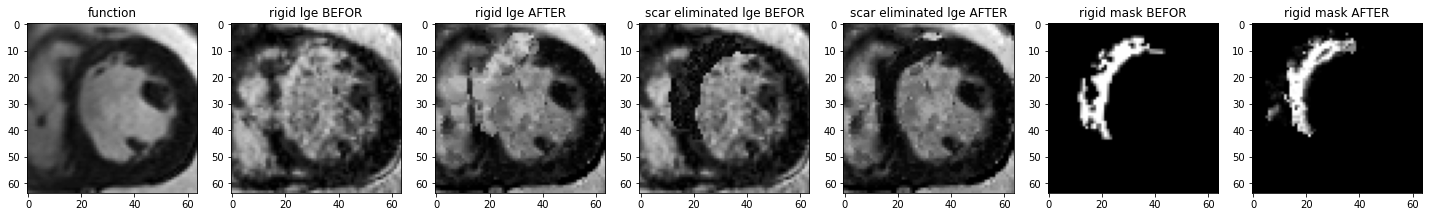

In [ ]:
sample =0
fig , (ax1 , ax2 , ax3 , ax4 , ax5 , ax6 , ax7) = plt.subplots(1,7,figsize = (25,12))
print(result_path_batch[sample])
ax1.imshow(fixed_batch[sample].squeeze(0).cpu() , cmap = 'gray')
ax1.set_title("function")

ax2.imshow(rigid_lge_batch[sample].squeeze(0).cpu() , cmap = 'gray')
ax2.set_title("rigid lge BEFOR")
ax3.imshow(voxel_lge[sample].squeeze(0).cpu() , cmap = 'gray')
ax3.set_title("rigid lge AFTER")

ax4.imshow(moving_batch[sample].squeeze(0).cpu() , cmap = 'gray')
ax4.set_title("scar eliminated lge BEFOR")
ax5.imshow(registered_images[sample].squeeze(0).cpu() , cmap = 'gray')
ax5.set_title("scar eliminated lge AFTER")

ax6.imshow(rigid_mask_batch[sample].squeeze(0).cpu() , cmap = 'gray')
ax6.set_title("rigid mask BEFOR")
ax7.imshow(voxel_mask[sample].squeeze(0).cpu() , cmap = 'gray')
ax7.set_title("rigid mask AFTER")

In [ ]:
mask = rigid_mask_batch[sample].squeeze(0).cpu().numpy()

In [ ]:
t = np.where(mask==0.39215687 , 0 , mask)

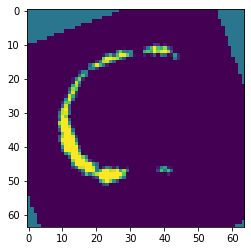

In [ ]:
plt.imshow(mask)

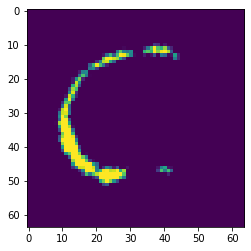

In [ ]:
plt.imshow(t)

In [ ]:
train_VoxelMorph(model , train_loader , epochs = 300 , model_name = "rigid_E300_L0.1_B1" , save_model=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 -0.7064821503610692
1 -0.7114608010675153
2 -0.7039580224925637
3 -0.713983271519343
4 -0.7109609877961314
5 -0.7174101852963113
6 -0.7190786308202988
7 -0.7170400958794814
8 -0.7210443260323288
9 -0.7203165845483797
10 -0.7217828863706344
11 -0.7180843712427677
12 -0.7196358153962682
13 -0.7238595385327299
14 -0.7236803431286771
15 -0.7159038895215744
16 -0.7204912356331817
17 -0.7228801876051814
18 -0.7234422815661145
19 -36.95346647340518
20 -0.38327539041001574
21 -0.4056597688513943
22 -0.4199730345581332
23 -0.4273109215701747
24 -0.4327426133502243
25 -0.4371909081426441


KeyboardInterrupt: ignored